#### Warning : code requres .csv files from here : https://www.kaggle.com/rounakbanik/the-movies-dataset  and a movie database api key

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import ast

In [4]:


#Credits
credits = pd.read_csv(".\credits.csv")
print("{0} {1} : {2}".format("credits.csv", credits.shape, credits.columns))
#Keywords
keywords = pd.read_csv(".\keywords.csv")
print("{0} {1} : {2}".format("keywords.csv", keywords.shape, keywords.columns))
#Links
links = pd.read_csv(".\links.csv")
print("{0} {1} : {2}".format("links.csv", links.shape, links.columns))
#MetaData
metadata = pd.read_csv(".\movies_metadata.csv")
print("{0} {1} : {2}".format("movies_metadata.csv", metadata.shape, metadata.columns))

def check_int(value):
    try:
        int(value)
        return np.NaN
    except ValueError:
        return value
    
def check_bool(value):
    try:
        bool(value)
        return np.NaN
    except ValueError:
        return value

credits.csv (45476, 3) : Index(['cast', 'crew', 'id'], dtype='object')
keywords.csv (46419, 2) : Index(['id', 'keywords'], dtype='object')
links.csv (45843, 3) : Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
movies_metadata.csv (45466, 24) : Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


C:\Users\Karl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### 1. Many types of ids in tables, verify 'id' is feature to merge on

In [5]:
#Find and drop invalid data in metadata
sub = metadata[['imdb_id','id','title']]

#tried to convert 'id' in metadata to int, but couldn't
#need to check values
invalid = sub['id'].apply(check_int).dropna()
print("Invalid Ids")
print(sub.loc[sub['id'].isin(invalid)])

cleansub = sub.loc[~sub['id'].isin(invalid)]
cleansub = cleansub.astype({'id':'int64'})
credit_meta = pd.merge(cleansub, credits, on='id')

credit_meta_keywords = pd.merge(credit_meta, keywords, on='id')

print()
print("Merged Tables")
print(credit_meta_keywords.dtypes)
print(credit_meta_keywords.columns)

Invalid Ids
      imdb_id          id title
19730       0  1997-08-20   NaN
29503       0  2012-09-29   NaN
35587       0  2014-01-01   NaN

Merged Tables
imdb_id     object
id           int64
title       object
cast        object
crew        object
keywords    object
dtype: object
Index(['imdb_id', 'id', 'title', 'cast', 'crew', 'keywords'], dtype='object')


##### Verified can merge on 'id', which means 'links.csv' not needed

### 2 - Extract important features from each csv, and cast to types

In [6]:
metaSubset = metadata[['adult', 'budget', 'genres', 'id','imdb_id',
       'original_language','popularity', 'production_companies','production_countries', 
        'release_date', 'revenue', 'runtime','spoken_languages', 'status', 
        'title', 'video','vote_average', 'vote_count']]

metaSubset = metaSubset.loc[~sub['id'].isin(invalid)]
metaSubset = metaSubset.astype({'adult':'bool', 
                                'budget':'float', 
                                'id':'int64',
                                'imdb_id':'string',
                                'original_language':'string',
                                'popularity':'float',
                                'runtime':'float',
                               'title':'string',
                               'video':'bool'})

metaSubset['release_date'] = pd.to_datetime(metaSubset['release_date'])


#cut unreleased films, then remove column
metaSubset = metaSubset[metaSubset['status']=='Released']
metaSubset = metaSubset.drop(columns = 'status')

#missing revenue for 37619 movies out of 43000 in dataset, remove column
print("Number of missing revenue values: {0}".format(len(metaSubset[metaSubset['revenue']<= 0])))
metaSubset = metaSubset.drop(columns= 'revenue')

print(metaSubset['production_countries'][0])

#genres, production_companies, production_countries come in as strings, interpret as objects(dictionaries, arrays, etc)
metaSubset['genres'] = metaSubset['genres'].apply(ast.literal_eval)
metaSubset['genreIds'] = metaSubset['genres'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_companies'] = metaSubset['production_companies'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCompIds'] = metaSubset['production_companies'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_countries'] = metaSubset['production_countries'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCountryId'] = metaSubset['production_countries'].apply(lambda x : [y['iso_3166_1'] for y in x])

Number of missing revenue values: 37619
[{'iso_3166_1': 'US', 'name': 'United States of America'}]


### credits table
##### (this one takes some time)

In [7]:
creditsSub = credits[['cast', 'crew','id']]
creditsSub = creditsSub


def ParseCrew(crewString):
    c = ast.literal_eval(crewString)
    if(len(c) == 0):
        return np.nan
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','job','name']} \
          for x in c if x['job'] in ['Director', 'Screenplay','Editor']  ]
    return c

creditsSub['crew'] = creditsSub['crew'].apply(ParseCrew)
print(creditsSub['crew'].head())



def ParseCast(castString):
    c = ast.literal_eval(castString)
    if(len(c) == 0):
        return np.nan
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','name']} \
          for x in c]
    return c
    
creditsSub['cast'] = creditsSub['cast'].apply(ParseCast)


0    [{'id': 7879, 'job': 'Director', 'name': 'John...
1    [{'id': 876, 'job': 'Screenplay', 'name': 'Jon...
2    [{'id': 26502, 'job': 'Director', 'name': 'How...
3    [{'id': 2178, 'job': 'Director', 'name': 'Fore...
4    [{'id': 17698, 'job': 'Screenplay', 'name': 'N...
Name: crew, dtype: object


In [8]:
creditsSub.head()

,cast,crew,id
0,"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...",862
1,"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...",8844
2,"[{'id': 6837, 'name': 'Walter Matthau'}, {'id'...","[{'id': 26502, 'job': 'Director', 'name': 'How...",15602
3,"[{'id': 8851, 'name': 'Whitney Houston'}, {'id...","[{'id': 2178, 'job': 'Director', 'name': 'Fore...",31357
4,"[{'id': 67773, 'name': 'Steve Martin'}, {'id':...","[{'id': 17698, 'job': 'Screenplay', 'name': 'N...",11862


### keywords table

In [9]:
keywordsSub = keywords[['id','keywords']]
keywordsSub['keywords'] = keywordsSub['keywords'].apply(ast.literal_eval)
keywordsSub.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## Merge Tables

In [31]:
allData = metaSubset.merge(creditsSub, on='id')
allData = allData.merge(keywordsSub, on='id')

allData.head(2)

,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,title,video,vote_average,vote_count,genreIds,productionCompIds,productionCountryId,cast,crew,keywords
0,True,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,Toy Story,False,7.7,5415.0,"[16, 35, 10751]",[3],[US],"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,True,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,Jumanji,False,6.9,2413.0,"[12, 14, 10751]","[559, 2550, 10201]",[US],"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [36]:
print("missing budget rows : {0}".format(len(allData[allData['budget']==0])))
allData = allData.drop(columns = 'budget')

missing budget rows : 37136


### replace budget and revenue from the movie db

In [112]:
from os.path import exists

if(exists('./money.csv')):
    df = pd.read_csv('./money.csv')
else:
    df = pd.DataFrame(columns=['id','budget', 'revenue'])

27008

In [113]:
import json
import time
f = open("./api.json")
j = json.load(f)

api = j['THE_MOVIE_DB_API']

from bs4 import BeautifulSoup
import requests as rq

print(api)

remaining = [x for x in allData['id'] if x not in df['id']]
for i in range(len(remaining)):
    movId = remaining[i]
    webread =rq.get('https://api.themoviedb.org/3/movie/{0}?api_key={1}'.format(movId,api))
    
    resp = webread.json()
    budget = np.nan
    if('budget' in resp.keys() and int(resp['budget']) !=0):
        budget = int(resp['budget'])
   
    revenue = np.nan
    if('revenue' in resp.keys() and int(resp['revenue']) !=0):
        revenue = int(resp['revenue'])
    
    df = df.append({'id': movId, 'budget': budget, 'revenue':revenue}, ignore_index=True)

    if(i % (len(remaining)//1000) == 0):
        print("{0} percent complete".format(float(i*100)/float(len(remaining))))
    #time.sleep(.1)
    
    

    

f09db215292b8cd0e2396d9423025a0e
0.0 percent complete
0.09997037914691943 percent complete
0.19994075829383887 percent complete
0.2999111374407583 percent complete
0.39988151658767773 percent complete
0.49985189573459715 percent complete
0.5998222748815166 percent complete
0.699792654028436 percent complete
0.7997630331753555 percent complete
0.8997334123222749 percent complete
0.9997037914691943 percent complete
1.0996741706161137 percent complete
1.1996445497630333 percent complete
1.2996149289099526 percent complete
1.399585308056872 percent complete
1.4995556872037914 percent complete
1.599526066350711 percent complete
1.6994964454976302 percent complete
1.7994668246445498 percent complete
1.8994372037914693 percent complete
1.9994075829383886 percent complete
2.099377962085308 percent complete
2.1993483412322274 percent complete
2.299318720379147 percent complete
2.3992890995260665 percent complete
2.4992594786729856 percent complete
2.599229857819905 percent complete
2.6992002369

23.09315758293839 percent complete
23.19312796208531 percent complete
23.293098341232227 percent complete
23.393068720379148 percent complete
23.493039099526065 percent complete
23.593009478672986 percent complete
23.692979857819907 percent complete
23.792950236966824 percent complete
23.892920616113745 percent complete
23.992890995260662 percent complete
24.092861374407583 percent complete
24.192831753554504 percent complete
24.29280213270142 percent complete
24.392772511848342 percent complete
24.49274289099526 percent complete
24.59271327014218 percent complete
24.692683649289098 percent complete
24.79265402843602 percent complete
24.89262440758294 percent complete
24.992594786729857 percent complete
25.092565165876778 percent complete
25.192535545023695 percent complete
25.292505924170616 percent complete
25.392476303317537 percent complete
25.492446682464454 percent complete
25.592417061611375 percent complete
25.692387440758292 percent complete
25.792357819905213 percent complete

46.286285545023695 percent complete
46.38625592417062 percent complete
46.48622630331754 percent complete
46.586196682464454 percent complete
46.68616706161137 percent complete
46.786137440758296 percent complete
46.88610781990521 percent complete
46.98607819905213 percent complete
47.086048578199055 percent complete
47.18601895734597 percent complete
47.28598933649289 percent complete
47.385959715639814 percent complete
47.48593009478673 percent complete
47.58590047393365 percent complete
47.685870853080566 percent complete
47.78584123222749 percent complete
47.88581161137441 percent complete
47.985781990521325 percent complete
48.08575236966825 percent complete
48.18572274881517 percent complete
48.285693127962084 percent complete
48.38566350710901 percent complete
48.485633886255926 percent complete
48.58560426540284 percent complete
48.68557464454976 percent complete
48.785545023696685 percent complete
48.8855154028436 percent complete
48.98548578199052 percent complete
49.08545616

69.67935426540285 percent complete
69.77932464454976 percent complete
69.87929502369668 percent complete
69.97926540284361 percent complete
70.07923578199052 percent complete
70.17920616113744 percent complete
70.27917654028435 percent complete
70.37914691943128 percent complete
70.4791172985782 percent complete
70.57908767772511 percent complete
70.67905805687204 percent complete
70.77902843601896 percent complete
70.87899881516587 percent complete
70.9789691943128 percent complete
71.07893957345972 percent complete
71.17890995260663 percent complete
71.27888033175356 percent complete
71.37885071090048 percent complete
71.47882109004739 percent complete
71.57879146919431 percent complete
71.67876184834124 percent complete
71.77873222748815 percent complete
71.87870260663507 percent complete
71.97867298578198 percent complete
72.07864336492891 percent complete
72.17861374407583 percent complete
72.27858412322274 percent complete
72.37855450236967 percent complete
72.47852488151659 perc

93.27236374407583 percent complete
93.37233412322274 percent complete
93.47230450236967 percent complete
93.57227488151659 percent complete
93.6722452606635 percent complete
93.77221563981043 percent complete
93.87218601895735 percent complete
93.97215639810426 percent complete
94.07212677725119 percent complete
94.17209715639811 percent complete
94.27206753554502 percent complete
94.37203791469194 percent complete
94.47200829383887 percent complete
94.57197867298578 percent complete
94.6719490521327 percent complete
94.77191943127963 percent complete
94.87188981042654 percent complete
94.97186018957346 percent complete
95.07183056872037 percent complete
95.1718009478673 percent complete
95.27177132701422 percent complete
95.37174170616113 percent complete
95.47171208530806 percent complete
95.57168246445498 percent complete
95.67165284360189 percent complete
95.77162322274881 percent complete
95.87159360189574 percent complete
95.97156398104265 percent complete
96.07153436018957 perce

In [139]:
df =df.drop_duplicates(subset=['id'])

moneyfile = "money.csv"
df.to_csv(moneyfile, sep=',', index = False)
print(len(df[~df['budget'].isna()]))
print(len(df[~df['revenue'].isna()]))
df.head()

10466
9409


,id,budget,revenue
0,862.0,30000000.0,373554033.0
1,8844.0,65000000.0,262797249.0
2,15602.0,25000000.0,71500000.0
3,31357.0,16000000.0,81452156.0
4,11862.0,NaN,76594107.0


cutting out 7 moivies with profit margin > 300000

count      6921.000000
mean        451.377504
std        3037.239174
min         -99.999906
25%         -25.627376
50%          95.211894
75%         307.978241
max      137700.000000
Name: profit_margin, dtype: float64

DataSet with profit Margin count: 6921


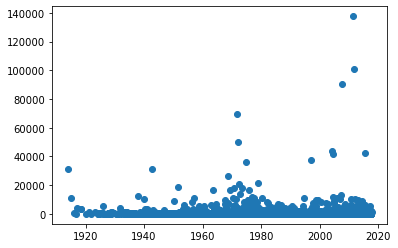

In [140]:
allData.drop_duplicates(subset=['id'])
dataset = allData.merge(df, on='id')

subDataSet = dataset[(~dataset['budget'].isna()) & (~dataset['revenue'].isna())]


subDataSet = subDataSet.assign(profit_margin = subDataSet.apply(lambda row: (row['revenue']-row['budget'])*100.0/row['budget'], axis=1).values)

profitMarginOutliers = subDataSet['profit_margin']>=300000
print("cutting out {0} moivies with profit margin > {1}".format(len(subDataSet[profitMarginOutliers]), 300000))
print()
reasonableMargin = subDataSet[~profitMarginOutliers]

print(reasonableMargin['profit_margin'].describe())
print()
print("DataSet with profit Margin count: {0}".format(len(reasonableMargin)))
plt.scatter(reasonableMargin['release_date'], reasonableMargin['profit_margin'])
plt.show()

### Write out Data Wrangled sets

In [141]:
marginFile = "resonableMargins.csv"
reasonableMargin.to_csv(marginFile, sep=',', index=False)

allDataFile = "allData.csv"
reasonableMargin.to_csv(allDataFile, sep=',', index=False)

count      5397.000000
mean        443.474030
std        2879.302413
min         -99.999906
25%         -14.553748
50%         106.198696
75%         312.463422
max      137700.000000
Name: profit_margin, dtype: float64

                                              title release_date  revenue
426    City Slickers II: The Legend of Curly's Gold   1994-06-10     43.0
932                                    East of Eden   1955-03-09      5.0
2199                                      Nashville   1975-06-11     10.0
2491                                   Lost & Found   1999-04-23    100.0
2677                        Never Talk to Strangers   1995-10-20      6.0
2896                        Dreaming of Joseph Lees   1999-10-29      7.0
3876                    Rugrats in Paris: The Movie   2000-09-14    103.0
3903                                        Pollock   2000-09-06      8.0
4956                                 American Adobo   2001-09-29      4.0
6664                           Same Tim

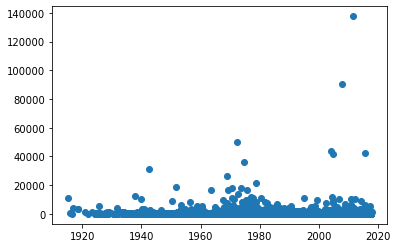

In [170]:
usMovies = reasonableMargin[reasonableMargin['production_countries'].apply(lambda x: any([y['iso_3166_1']=='US' for y in x]))]

len(usMovies)
print(usMovies['profit_margin'].describe())
print()

print(usMovies[usMovies['revenue']< 1000][['title','release_date','revenue']])

plt.scatter(usMovies['release_date'], usMovies['profit_margin'])
plt.show()